In [8]:
import numpy as np
import torch
from rocket import Rocket
from torch.utils.data import DataLoader, TensorDataset, random_split # added
# from TestNetwork import ActorCritic
# from PPO_network import VNetwork, PolicyNetwork
import matplotlib.pyplot as plt
import utils
import os
import glob
import time
import datetime
from collections import deque
import torch.optim as optim
import cv2

import torch.nn as nn

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # this line was added to avoid kernel error within my environment


# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:

class PositionalMapping(nn.Module):
    """
    Positional mapping Layer.
    This layer map continuous input coordinates into a higher dimensional space
    and enable the prediction to more easily approximate a higher frequency function.
    See NERF paper for more details (https://arxiv.org/pdf/2003.08934.pdf)
    """

    def __init__(self, input_dim, L=5, scale=1.0):
        super(PositionalMapping, self).__init__()
        self.L = L
        self.output_dim = input_dim * (L*2 + 1)
        self.scale = scale

    def forward(self, x):

        x = x * self.scale

        if self.L == 0:
            return x

        h = [x]
        PI = 3.1415927410125732
        for i in range(self.L):
            x_sin = torch.sin(2**i * PI * x)
            x_cos = torch.cos(2**i * PI * x)
            h.append(x_sin)
            h.append(x_cos)

        return torch.cat(h, dim=-1) / self.scale

# Based on the code from https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/
# Network architecture and hyperparameters are based on : https://arxiv.org/pdf/2006.05990.pdf
# The code below is taken from: https://github.com/huggingface/deep-rl-class/blob/main/notebooks/unit8/unit8_part1.ipynb


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class NetworkLayer(nn.Module):
    def __init__(self, input_dim, output_dim) -> None:
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.layer = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output_dim), std=1.0),
        )
    def forward(self, x):
        x = x.view([1, -1])
        x =  self.mapping(x)
        x = self.layer(x)
        return x

class VNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
    def forward(self, x):
        #x = x.view([1, -1]) # removed
        x = self.mapping(x)
        x = self.critic(x)
        return x


class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.actor = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output_dim), std=1.0),
        )
        
    def forward(self, x):
        #x = x.view([1, -1]) # removed
        x = self.mapping(x)
        x = self.actor(x)
        x = torch.nn.functional.softmax(x, dim=-1)
        return x

# class PPOAgent(torch.nn.Module):
#     def __init__():
#         super().__init__()
#         self.lr = 2.5e-4
#         self.gamma = 0.99
#         self.lmbda         = 0.99
#         self.eps_clip      = 0.1
#         self.K_epoch       = 4
#         self.batch_size    = 64
#         self.policy_net = PolicyNetwork()
#         self.policy_target = PolicyNetwork()
#         self.policy_target.load_state_dict(self.policy.parameters())
#         self.value_net = VNetwork()
        
    


def gen_episode(environment, policy_target, device, max_step = 800):
    states = []
    actions = []
    rewards = []
    ratios = []
    state = environment.reset() 
    terminated = False

    for step in range(max_step):
        probs_target = policy_target(torch.FloatTensor(state).to(device))
        action = torch.multinomial(probs_target, 1).item()
        
        next_state, reward, terminated, _ = environment.step(action) 
        #must add:
        #environment.render()
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        if terminated:
            #cv2.destroyAllWindows()
            break
        state = next_state
    return states, actions, rewards


In [10]:
task = 'landing'  # 'hover' or 'landing'
version = 5

max_m_episode = 200000
max_steps = 800
     #network and optimizer

    #hyperparameters:
alpha = 2.5e-4
gamma = 0.99
lmbda         = 0.99
eps_clip      = 0.2
K_epoch       = 4
entropy_coeff = 0.01
SAVE_INTERVAL = 1000
mini_batch_size = 64
env = Rocket(task=task, max_steps=max_steps)


    #create networks:
pi = PolicyNetwork(env.state_dims, env.action_dims)
pi_optimizer = torch.optim.Adam(pi.parameters(), lr=alpha)
pi_target = PolicyNetwork(env.state_dims, env.action_dims)

V = VNetwork(env.state_dims)
V_optimizer = torch.optim.Adam(V.parameters(), lr=alpha)  

V = V.to(device)
pi = pi.to(device)
pi_target = pi_target.to(device)

    
ckpt_folder = os.path.join('./', task + '_ckpt')
if not os.path.exists(ckpt_folder):
    os.mkdir(ckpt_folder)

In [ ]:
episode = 0
MAX_EPISODES = 20000
reward_history =[]
reward_history_100 = deque(maxlen=100)

while episode < MAX_EPISODES:  # episode loop
        
    pi_target.load_state_dict(pi.state_dict())
    states, actions, rewards = gen_episode(env, pi_target, device, max_steps)
    
    GAEs = []
    Gs = []
    GAE = 0
    G = 0
    
    values = V(torch.FloatTensor(np.array(states)).to(device)).view(-1)
    
    for t in range(len(states) - 2, -1, -1):
        if t < len(rewards):
            delta = rewards[t] + gamma * values[t + 1] - values[t]
        else:
            delta = rewards[t] - values[t]
        GAE = gamma * lmbda * GAE + delta
        GAEs.insert(0, GAE)
        G = gamma * G + rewards[t]
        Gs.insert(0, G)
            
            
            
    GAEs = torch.FloatTensor(GAEs).to(device)
    Gs = torch.FloatTensor(Gs).to(device)
    
    states = np.array(states)
    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(actions).to(device)
    #rewards = torch.FloatTensor(rewards).to(device)
    
    states = states[:-1]
    actions = actions[:-1]

    dataset = TensorDataset(states, actions, GAEs, Gs)
    #dataloader = DataLoader(dataset, batch_size=mini_batch_size)
    dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)
    
    episode += 1    
    for k in range(1,K_epoch):
        for batch_states, batch_actions, batch_GAEs, batch_Gs in dataloader:
            loss1 = 0
            loss2 = 0
            entropy_mean = 0
            values = V(batch_states).view(-1)
            
            actor_outputs = pi(batch_states)
            actor_target_outputs = pi_target(batch_states)

            for t in range(len(batch_states)):
                #S = batch_states[t]
                A = batch_actions[t]
                ratio = actor_outputs[t][A] / actor_target_outputs[t][A]

                entropy_mean -= torch.distributions.Categorical(probs=actor_outputs[t]).entropy()

                surr1 = ratio * batch_GAEs[t]
                surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * batch_GAEs[t]
                loss1 = loss1 - torch.min(surr1, surr2)
            
            loss2 = ((batch_Gs - values) ** 2).mean()
            loss1 += entropy_coeff * entropy_mean / len(batch_states)

            pi_optimizer.zero_grad()
            loss1.backward(retain_graph=True)
            pi_optimizer.step()

            V_optimizer.zero_grad()
            loss2.backward()
            V_optimizer.step()
            
    reward_history.append(G)                
        
    if episode % 10 == 1:
        print('episode id: %d, episode return: %.3f'
                % (episode, G))
        torch.save({'episode_id': episode,
                            'REWARDS': reward_history,
                            'model_pi_state_dict': pi.state_dict(),
                            'model_V_state_dict': V.state_dict(),
                            'model_pi_optimizer': pi_optimizer.state_dict(),
                            'model_V_optimizer': V_optimizer.state_dict()},
                           os.path.join(ckpt_folder, 'ckpt_' + str(version).zfill(8) + '.pt'))
        plt.figure()
        plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
        plt.legend(['episode reward', 'moving avg'], loc=2)
        plt.xlabel('m episode')
        plt.ylabel('return')
        plt.savefig(os.path.join(ckpt_folder, 'rewards_' + str(version).zfill(8) + '.jpg'))
        plt.close()

    
    if episode % SAVE_INTERVAL == 0:
        torch.save({'episode_id': episode,
                            'REWARDS': reward_history,
                            'model_pi_state_dict': pi.state_dict(),
                            'model_V_state_dict': V.state_dict(),
                            'model_pi_optimizer': pi_optimizer.state_dict(),
                            'model_V_optimizer': V_optimizer.state_dict()},
                            os.path.join(ckpt_folder, 'ckpt_' + str(SAVE_INTERVAL).zfill(8) + '.pt'))

episode id: 1, episode return: 2.725
episode id: 11, episode return: -1.035
episode id: 21, episode return: 2.129
episode id: 31, episode return: 1.732
episode id: 41, episode return: -1.624
episode id: 51, episode return: 1.669
episode id: 61, episode return: -1.389
episode id: 71, episode return: 0.303
episode id: 81, episode return: -0.940
episode id: 91, episode return: 6.603
episode id: 101, episode return: 5.407
episode id: 111, episode return: 2.848
episode id: 121, episode return: 0.788
episode id: 131, episode return: 0.585
episode id: 141, episode return: 1.691
episode id: 151, episode return: 2.461
episode id: 161, episode return: 1.892
episode id: 171, episode return: 4.632
episode id: 181, episode return: 4.003
episode id: 191, episode return: 1.515
episode id: 201, episode return: 8.838
episode id: 211, episode return: 4.056
episode id: 221, episode return: 3.062
episode id: 231, episode return: 4.434
episode id: 241, episode return: 1.265
episode id: 251, episode return:

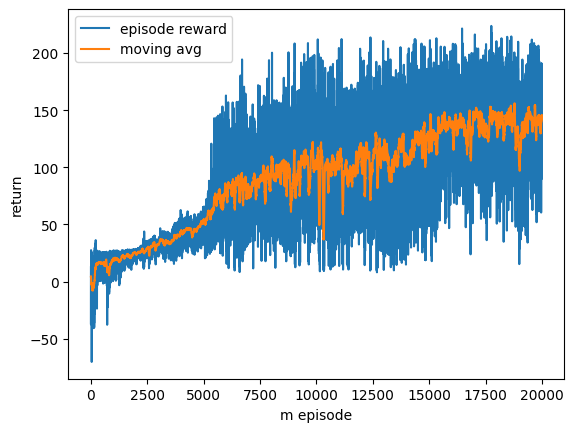

In [7]:
plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
plt.legend(['episode reward', 'moving avg'], loc=2)
plt.xlabel('m episode')
plt.ylabel('return')
plt.show()

In [14]:
task = 'landing'  # 'hover' or 'landing'
max_steps = 800
gamma = 0.99
ckpt_dir = glob.glob(os.path.join(task+'_ckpt', '*.pt'))[-1]  # last ckpt

print(ckpt_dir)
env_test = Rocket(task=task, max_steps=max_steps)
pi_test = PolicyNetwork(env_test.state_dims, env_test.action_dims)
pi_test = pi_test.to(device)
    
if os.path.exists(ckpt_dir):
    checkpoint = torch.load(ckpt_dir, map_location=torch.device(device))
    pi_test.load_state_dict(checkpoint['model_pi_state_dict'])

state = env_test.reset()
episode_returns = list()
for i in range(1):
    _, _, rewards = gen_episode(env_test, pi_test, device, max_steps)
    G = 0
    for t in range(len(rewards) - 2, -1, -1):
        R = rewards[t]
        G = gamma * G + R
    print(rewards)

    episode_returns.append(G)

average_return = sum(episode_returns) / len(episode_returns)
print(average_return)
print(average_return / 120)

landing_ckpt\ckpt_00001000.pt
[0.02145433637286398, 0.021872552355188313, 0.022292962364612492, 0.022724052779990556, 0.023166798608270433, 0.023640496053765583, 0.024176360997517233, 0.024784177989005642, 0.02547367489817715, 0.02625451585980241, 0.027136294387200215, 0.028128526644011845, 0.02924064485916296, 0.030481990866798182, 0.031858696035938744, 0.033372157300276234, 0.035022194211000085, 0.03680861271668498, 0.038731204372616734, 0.0407897454695734, 0.04298399609174045, 0.045252149892068765, 0.04753204434517325, 0.049822713683750505, 0.0521231822311887, 0.054432465181729096, 0.056749569395377314, 0.059073494206502195, 0.0614032322449838, 0.0637377702687005, 0.06607659006067874, 0.06841917082579757, 0.07076448960887999, 0.07311152022631592, 0.07545923413248845, 0.07780660129026365, 0.08015259104402928, 0.08249617299374933, 0.08483631786849155, 0.0871719983978857, 0.08950219017997832, 0.09182687492748762, 0.09397527819556559, 0.09606179323334074, 0.0981441506627792, 0.100221394